# This is a Man's word

Exploring gender equality through quotes in media

## Project setup

Mouting the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing dependencies

In [2]:
# Toggle in order to install dependencies as you run the notebook
INSTALL_DEPS = True

In [ ]:
if INSTALL_DEPS:
  !pip install empath
  !python -m spacy download en
  !python -m nltk.downloader punkt
  !python -m nltk.downloader all-corpora
  !pip install fastparquet
  !pip install pyLDAvis
  !pip install "openpyxl>=3.0"
  !pip3 install pickle5
  !pip install -Uqq ipdb
  !pip install --upgrade gensim

In [2]:
%pdb off

Automatic pdb calling has been turned OFF


Definition of main colors used for the plots

In [24]:
grey = '#d9d9d9'
blue = '#1E88E5'
pink = '#FFB6C1'
dark_pink = '#ff6b81'
dark_blue = '#0e81e6'

### Importing libraries

In [ ]:
import pandas as pd
import bz2
import json
import string
import re
import matplotlib.pyplot as plt
import matplotlib
import requests
import nltk
import gc
import ipdb
import os
import plotly
from math import ceil
import numpy as np

import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
from functools import partial
from toolz import compose
from itertools import product
import pickle5 as pickle
from datetime import datetime

import seaborn as sns
import plotly.express as px
from plotly.graph_objs import Layout

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from scipy import stats

In [ ]:
if INSTALL_DEPS:
  nltk.download('punkt')
  nltk.download('wordnet')
  nltk.download('stopwords')
  nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


We disable the warnings - in general it's a bad practice and should be avoided in any longer-maintained project. Nonetheless, while training the model we get a warning about a deprecated function in one of the dependencies - it's prints the message thousands of times and thus slows down the training phase and affects readability.

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Loading dataset

In [6]:
def get_path_to_file(year):
  return f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'

def load_speaker_attrs():
  return pd.read_parquet("/content/drive/MyDrive/Project datasets/speaker_attributes.parquet")

def load_attrs_labels():
  return pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

def get_wikidata_uri(q):
  return f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={q}&languages=en&format=json"

## Processing speaker attributes

We now add speaker attributes to the quotebank dataset.

### Resolving Q-codes


Speakers dataset was given with encoded attributes as wikipedia Q-codes, thus we need to resolve to meaningful human readable names.

In [7]:
def resolve_q_code(labels, q):
  '''Returns label of the QCODE if found.'''
  try:
    return labels.loc[q]['Label']
  except KeyError:
    return None

def untangle_codes(codes, labels):
  discard_none = lambda xs: filter(lambda x: x is not None, xs)
  resolve_code = partial(resolve_q_code, labels)
  return compose(
    list,
    discard_none,
    partial(map, resolve_code)
  )(codes)

def interpolate_q_codes_new_way(df, labels, columns):
  '''Adds labeled features to the df.'''
  for col in columns:
    df[col] = df[col].apply(lambda codes: untangle_codes(codes, labels) if codes is not None else None)

We want to associate the quote's speaker with an entry in speaker attributes dataframe. However, since in the Quotebank aliases might have been used, we construct an **Alias Name -> Index in Speaker attrs** mapping. This mapping is then left-joined with quote's speaker and with speaker attrs so that we can have full speaker metadata for a quote, even if alias was used.

In [8]:
def construct_speaker_names(speaker_attrs):
  """Associates the speaker attributes index with all speaker aliases"""
  
  speaker_names = speaker_attrs.aliases.explode().append(speaker_attrs.label)
  speaker_names = speaker_names.drop(speaker_names[speaker_names.isna()].index)

  speaker_names_df = pd.DataFrame({"speaker": speaker_names, "speaker_attr_idx": speaker_names.index})
  speaker_names_df = speaker_names_df.set_index('speaker')
  return speaker_names_df


def clean_speaker_attrs(speaker_attrs):
  return speaker_attrs[['nationality', 'gender', 'occupation', 'label']].copy()

In [9]:
# If more columns with q-codes need to be resolved they should be added here
Q_CODES_COLUMNS = ['nationality', 'occupation', 'gender']


def process_speaker_attrs():
  speaker_attrs = load_speaker_attrs()
  attrs_labels = load_attrs_labels()

  interpolate_q_codes_new_way(speaker_attrs, attrs_labels, Q_CODES_COLUMNS)
  speaker_names_df = construct_speaker_names(speaker_attrs)
  trimmed_speaker_attrs = clean_speaker_attrs(speaker_attrs)

  return trimmed_speaker_attrs, speaker_names_df

**Run speaker attributes processing**

In [ ]:
# Toggle to 1 if you want to re-proces attrs (most likley you don't want to)
REPROCESS_SPEAKER_ATTRS = False

if REPROCESS_SPEAKER_ATTRS:
  speaker_attrs, speaker_names_df = process_speaker_attrs()
  speaker_attrs.to_pickle("/content/drive/MyDrive/ADA/speaker_attrs__no_aliases.pkl")
  speaker_names_df.to_pickle("/content/drive/MyDrive/ADA/speaker_names_df.pkl")

**Load cached processed speaker attributes**

In [ ]:
# Toggle to 1 if you need speaker attributes in your further processing
# Note that later we merge it with quotes dataset so most likley it's not necessary
LOAD_SPEAKER_ATTRS = False

if LOAD_SPEAKER_ATTRS:
  speaker_attrs = pd.read_pickle("/content/drive/MyDrive/ADA/speaker_attrs__no_aliases.pkl")
  speaker_names_df = pd.read_pickle("/content/drive/MyDrive/ADA/speaker_names_df.pkl")

**Caching intermediate results**

Processing speaker attrs due to its size takes time, and so does any preprocessing that we will do below with Quotebank dataset. In order to significantly speed up development, we don't want to rerun it but rather do it once and then leverage the results as a whole team.

For that purpose, we save results of time-consuming steps as pickles, python's native object serialization format, which are then uploaded into common google drive folder.

## Loading Human Development Index

We download now the Human Development Index dataset (HDI). The first nationality mentioned in the dataset for a given speaker is the one that we will match with the corresponding HDI score. HDI is represented as a number from 0 to 1, but we narrow down ourselves to four categories of developemnt:

1. Very High
1. High
1. Medium
1. Low

with ranges defined by United Nations.

In [ ]:
def load_HDI():
  return pd.read_excel('/content/drive/MyDrive/ADA/HDI_list.xlsx')


def merge_HDI_with_chunk(chunk_df):
  '''Merges HDI score with speaker's first nationality'''

  chunk_df['N'] = [next(iter(nationality), ' ') for nationality in chunk_df['nationality']]
  chunk_df = pd.merge(chunk_df, HDI, on='N') 
  return chunk_df


def merge_speaker_attrs_with_chunk(chunk_df):
  '''Merges speakers attributes data based on speaker column'''  
  chunk_df = chunk_df.join(speaker_names_df, on='speaker')

  # discard quotes for which the speaker could not be found
  chunk_df = chunk_df.drop(chunk_df[chunk_df.speaker_attr_idx.isna()].index)
  return chunk_df.join(speaker_attrs, on='speaker_attr_idx')

In [ ]:
HDI = load_HDI()

##  Classifying occupations

After looking at the 700 most common occupations, we manually created "buckets" ressembling similar jobs into 5 main categories:

1.   **Sports**: athletes and people involved in the management or organization of teams: football player, association football manager, swimmer, rower, race car driver...
2.   **Media**: journalist, television presenter, fashion model, influencer, web developer...

3.   **Important people**: it composes of 3 subcategories of influencial people
- involved in the world of business (economist, investment banker, business executive...)
- politics or state responsabilities (governor, deputy, minister...)
- military service (military officer, military leader...)

4.   **Arts**: actor, writer, painter, singer...

5.   **Academics**: scientists specialized in different fields and personnel in the healthcare domain (data scientist, engineer, veterinarian, epidemiologist...)

We chose these categories as they include supposed men-dominant professions, for example in the fields of sports and politics, but also some thought to be more equally represented, such as in the domain of academics or arts. We will use that in further analyses to assess the stereotype.

We will classify as 'Other' all those rows whose speaker's profession does not fall into one of our categories. In the case of speakers with multiple occupations, each of them will be classified as mentioned above.

In [ ]:
def load_jobs_types():
  JOBS_TYPES = ["sports", "media", "important_people", "art", "academics"]
  jobs = {}

  for job_type in JOBS_TYPES:
    with open(f"/content/drive/MyDrive/ADA/jobs_{job_type}.txt", 'r') as f:
        text = [line for line in f.read().split('\n')]
    jobs[job_type] = list(filter(bool, text))

  return jobs


def embed_occupation_class(chunk_df):
  job_types = load_jobs_types()

  class_occupation = []
  for val in chunk_df.occupation:
    person_occ = set()
    for occ in val:
      for job_type, jobs in job_types.items():
        if occ in jobs:
          person_occ |= {job_type}
          break
      else:
        person_occ |= {"Other"}

    class_occupation.append(list(person_occ))

  chunk_df["Class_Occup"] = pd.Series(class_occupation)
  return chunk_df


def clean_occupation(chunk_df):
  '''Drops rows with missing occupation.'''
  discard_na(chunk_df, 'occupation')
  return chunk_df


def save_most_common_jobs(df):
    occ = df['occupation'].explode()
    jobs = list(dict(Counter(occ).most_common(700)).keys())

    with open("/content/drive/MyDrive/ADA/jobs.txt", "w") as f:
      for job in jobs:
        if job is not None:
          f.write(job + "\n")

## Data cleaning

### Quotation cleaning

As the quotations will be the focus of a significant part of our further analysis, we designed the following pipeline to preprocess them: 

1. First, the quotes are normalized: they are **lower-cased** and **punctuation marks** and **extra white** spaces are removed. 

1. Then, each quote is **tokenized** into a list of words. 

1. We train a model to find **bigrams** among the tokenized quotes. Bigrams are pairs of words that often co-occur in given contexts, like _Prime Minister_ or _United States_. We would like to find only those pairs of words that form a meaningful bigram. In order to do so, we first need to introduce the notion of **Pointwise Mutual Information (PMI)** score for two words _c_ and _w_: 
  $PMI(c, w) = log\frac{Pr(c, w)}{Pr(c) Pr(w)}$

  This measure indicates how much more likely the two words _c_ and _w_ co-occur than if they were independent. However, this method is very sensitive to rare combinations of words: for example, if _'foo bar'_ appear once together as a bigram, but _'foo'_ and _'bar'_ individually are not present in the text, this will result in a high PMI score for the bigram _'foo bar'_. 
To overcome this limitation, we will combine this method with a frequency filter to retain only those bigrams that appear at least a number of times (_mincount_), which we decided to be **10**.
Finally, we also set a *threshold* to **100** such that a phrase of words _a_ and _b_ is accepted if:  $N \frac{count(a, b) - min count } {count(a)  count(b)} > threshold$ , where _N_ is the total vocabulary size.

1. Then, we apply a part-of-speech tagger (**POS-tagger**) to the extracted sequence of words which attaches a part of speech tag to each of them. Some examples of these tags are: _RB_ for adverbs, _NN_ for nouns, _VB_ for verbs, _CC_ for coordinating junctions etc. [1] 
The motivation behind this step is that some words in a sentence tipically provide more context and explanation about a topic than others. For this reason, we defined a list of tags corresponding to the part of speech to discard such as verbs, adverbs, pronouns and others. The assumption behind our reasoning is that filtering for (mainly) **nouns and adjectives** extracts words that are more interpretable for the topic model to be applied later. 

1. We imported a list of **stopwords** for the English language to discard from the quotes and we manually wrote a list of words/bigrams to ignore, which are not meaningful for any topic in particular, such as _there_, _people_, *wan_na* etc. 

1. Finally, we lemmatized the remaining words. **Lemmatization** converts words to their base form given the contextual information: for example, the words _wait_, _waiting_, _waited_, _waits_ are all lemmatized to _wait_. We then discard those words, whose lemmatized form is shorter than $2$ letters. 

This pipeline allowed us to extract from each sentence **keywords** to be classified into topics later on.

[1] https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [ ]:

lem = WordNetLemmatizer()

IGNORED_KEYWORDS_FOR_TOPICS = ['there', "little_bit", "got_ta", "wan_na", "gon_na", 'people', 'time', 'like', 'one', 'get', 'think', 'going', 'would', 'want', 'dont', 'need', 'know', 'really', 'good', 'thing', 'make', 'well', 'way', 'see', 'day', 'work', 'thats', 'lot', 'come', 'got', 'game', 'back', 'right', 'take', 'also', 'new', 'many', 'first', 'much', 'great', 'could', 'say', 'every', 'always', 'best', 'look', 'even', 'something', 'last', 'two', 'ive', 'still', 'important', 'keep', 'put', 'part', 'today', 'made', 'give', 'there', 'around', 'said', 'week', 'together', 'big', 'place', 'didnt', 'done', 'able', 'cant', 'working', 'sure', 'different', 'next', 'everyone', 'bit', 'change', 'little', 'end', 'youre', 'must', 'continue', 'long' , 'hard', 'everything', 'let', 'may', 'situation', 'point', 'getting', 'coming', 'theyre', 'three', 'thought', 'forward', 'kind', 'moment', 'away', 'looking', 'trying', 'stay', 'try', 'month', 'another', 'possible', 'believe', 'without', 'making', 'wanted', 'came', 'difficult', 'find', 'doesnt', 'anything', 'use', 'ever', 'person', 'problem', 'child', 'already', 'across', 'since', 'real', 'challenge', 'ensure', 'step', 'plan', 'might', 'experience', 'enough', 'seen', 'someone', 'actually', 'probably', 'far', 'tell', 'hand', 'matter', 'happen', 'whole', 'understand', 'quite', 'used', 'chance', 'clear', 'went', 'talk', 'bring', 'taking', 'whether', 'result', 'taken', 'given', 'started', 'open', 'obviously', 'feel', 'better', 'never', 'weve', 'show', 'guy', 'happy', 'start', 'decision', 'mean', 'young', 'strong', 'nothing', 'run', 'high', 'fact', 'become', 'four', 'wasnt', 'move', 'five', 'maybe', 'told', 'ready', 'happened', 'left', 'tough', 'saying', 'especially', 'knew', 'thank', 'took', 'anyone', 'huge', 'wont', 'yet', 'within', 'else', 'saw', 'sometimes', 'definitely', 'needed', 'name', 'talking', 'playing', 'play', 'played', 'pretty', 'second', 'group', 'call', 'question', 'reason', 'bad', 'amazing', 'nice', 'easy', 'including', 'shes', 'youve', 'havent', 'couldnt', 'absolutely', 'whatever', 'gave', 'towards', 'true', 'whats', 'gone', 'certainly', 'theyve', 'almost', 'yes', 'wouldnt', 'isnt', 'though', 'seeing', 'rather', 'giving', 'however', 'along', 'often', 'certain', 'completely', 'either', 'available', 'particularly', 'standard', 'successful', 'extremely', 'common', 'among', 'somebody', 'yeah', 'instead', 'ago', 'were', 'arent']
part_of_speech_to_discard = ['IN', 'DT', 'CC', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS', 'POS', 'PRP', 'PRP']


def normalize_quote(s:str) -> str:
    """
    Lower text, remove punctuation and extra whitespace.
    """
    
    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_punc(lower(s)))


def tokenize_words(series):
    """
    Tokenizes normalized quotes.
    """
    return series.apply(compose(nltk.tokenize.word_tokenize, normalize_quote))


def train_bigrams_model(tokenized_words):
  bigram = gensim.models.Phrases(tokenized_words, min_count=10, threshold=100)
  return gensim.models.phrases.Phraser(bigram)


def embed_bigrams(tokenized_words):
  bigram_model = train_bigrams_model(tokenized_words)
  return tokenized_words.apply(lambda x: bigram_model[x])


def filter_useless_speach_parts(words):
  # reference: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
  return [
    word for word, tag in nltk.pos_tag(words)
    if str(tag) not in part_of_speech_to_discard
  ]


def extract_keywords(tokenized_words):
  """
  - Tokenize text
  - Excluded stop words
  - Lemmatized resulting keywords
  """

  stopwords = nltk.corpus.stopwords.words('english')
  filtered_words = filter_useless_speach_parts(tokenized_words)

  return [
    lem.lemmatize(word)
    for word in filtered_words
    if word not in stopwords
       and len(lem.lemmatize(word)) > 2
       and word not in IGNORED_KEYWORDS_FOR_TOPICS
       and lem.lemmatize(word) not in IGNORED_KEYWORDS_FOR_TOPICS
  ]


def drop_empty_keywords(chunk_df):
  AT_LEAST_KEYWORDS = 2
  return chunk_df[chunk_df.keywords.apply(
      lambda x: x if len(x) >= AT_LEAST_KEYWORDS else None
  ).notna()]


### Features Cleaning

Here we proceed to clean the data features by discarding all those rows with:

* **Missing speaker or speaker probability of quote attribution is lower than $60$%**. We wish to retain only those quotations attributed to a certain speaker with a "high" level of confidence. 
* **Missing speaker's gender or gender different from _male_ and _female_**. Even though it would have been interesting to embark on analysis of inequality with respect to LGBT speakers, we do not have sufficient data to draw any conclusions from it, thus we also discard it and leave only male and female speakers.
* **Missing speaker's nationality**: this information is particularly useful for our purpose to compare the representation of gender in developed vs developing countries, thus for each quote we need to be able to classify it based on the HDI rank of the speaker's country of origin
* **Number of occurrences = 1**: the assumption behind this criteria is that quotations that appeared only once in the media may not have had an impact or are not discussed worldwide.

In [ ]:
def discard_na(df, col):
  '''Drops rows with col value equal to None.'''
  df[col].replace('None', pd.NA, inplace=True)
  df.drop(df[df[col].isna() == True].index, inplace=True)


def clean_speaker(chunk_df):
  discard_na(chunk_df, 'speaker')
  return chunk_df


def clean_gender(chunk_df):
  '''Drops rows with missing gender.'''
  clean = lambda x: x[0] if x is not None and x[0] in ["male", "female"] else None
  chunk_df['gender'] = chunk_df['gender'].apply(clean)
  discard_na(chunk_df, 'gender')
  return chunk_df


def clean_nationality(chunk_df):
  '''Drops rows with missing nationality.'''
  discard_na(chunk_df, 'nationality')
  return chunk_df


def drop_nonfrequent_quotes(chunk_df):
  return chunk_df[chunk_df["numOccurrences"] > 1]


def drop_uncertain_speakers(chunk_df):
  return chunk_df[chunk_df.probas.apply(lambda x: x[0][1]).astype(float) > 0.6]

### Preprocess chunks

All the previous quotation and features cleaning operations are called in the function _preprocess chunk_. In order to be able to read the entire Quotebank data without encourring into memory issues, we read it by **chunks** of size one million rows. We only retain columns corresponding to our features, to reduce the dataset size. 

In [ ]:
COLUMNS_OF_INTEREST = [
  'numOccurrences', 'gender', 'occupation',
  'nationality', 'keywords', 'Class_Occup',
  'HDI rank', 'Development', 
]

def preprocess_chunk(chunk_df):
  '''
  Apply basic preprocessing and data cleaning to a chunk
  - Merge the chunk with the speaker attributes and HDI indexes
  - Remove rows with missing speakers, nationalities, genders and occupations
  - Process features in a format more appropriate for our use case
  '''
  chunk_df = compose(
    embed_occupation_class,
    merge_HDI_with_chunk,
    clean_occupation,
    clean_gender,
    clean_nationality,
    merge_speaker_attrs_with_chunk,
    clean_speaker,
    drop_uncertain_speakers,
    drop_nonfrequent_quotes,
  )(chunk_df)

  chunk_df['keywords'] = pd.Series(compose(
      lambda s: s.apply(extract_keywords),
      embed_bigrams,
      tokenize_words,
  )(chunk_df.quotation))

  chunk_df = drop_empty_keywords(chunk_df)

  chunk_df.rename({"N": "nationality", "HDI rank": "HDI_rank"}, inplace=True)
  chunk_df = chunk_df[COLUMNS_OF_INTEREST]
  return chunk_df

We apply the following pipeline to read and process the Quotebank dataset: 

1. We preprocess chunks them, save them in a **pickle format file**, then free the RAM memory.

1. We concatenate the files from the same year into a unique pickle file. 

1. We repeat steps 1. and 2. for every Quotebank data file specific for the years between 2015 and 2020. 

1. We concatenate the preprocessed files from all the years into a unique file. In order to keep track of the year from which each subset of lines is loaded, we add a column _Year_ to the dataframe with the corresponding value for each quote. This will be used to investigate the evolution of features across the years.


In [ ]:
def iterate_chunks(year, chunk_size, num_of_chunks):
  """
  Extracts a number of chunks from the file corresponding to the specified year.
  """

  with bz2.open(get_path_to_file(year), 'rb') as file:
    lines = []

    for i, line in enumerate(file):
      lines.append(json.loads(line))

      if i % chunk_size == 0 and i != 0:
        yield pd.DataFrame(lines)
        del lines[:]
        lines = []

        if i / chunk_size == num_of_chunks:
           return

    yield pd.DataFrame(lines)
    del lines[:]


def preprocess_chunks_in_year(year, chunk_size = 100_000, num_of_chunks=10):
  """Preprocesses a number of chunks extracted by calling the iterate_chunks function.
  """

  for i, chunk_df in enumerate(iterate_chunks(year, chunk_size, num_of_chunks)):
      print(f"[{datetime.now()}] Pre-processing chunk {i+1} out of {num_of_chunks}")

      processed_chunk_df = preprocess_chunk(chunk_df)
      yield processed_chunk_df
      gc.collect()


def preprocess_and_cache_chunks(year):
  """
  Run preprocessing and cache intermediate results in the pickle format
  """

  for i, processed_chunk in enumerate(preprocess_chunks_in_year(year, chunk_size=500_000, num_of_chunks=100)):
    processed_chunk.to_pickle(f'/content/drive/MyDrive/ADA/chunk_{year}_{i}.pkl')
  return i


def concatenate_preprocessed_chunks(year, chunks_count=6):
  """Concatenates pickle files from the same year.
  """

  get_filename = lambda i: f'/content/drive/MyDrive/ADA/chunk_{year}_{i}.pkl'
  chunks = [pd.read_pickle(get_filename(i)) for i in range(chunks_count)]
  df = pd.concat(chunks)
  df = df.reset_index()
  df.to_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes_{year}.pkl')

  for i in range(chunks_count):
    os.remove(get_filename(i))

  return df


def read_preprocessed_from_year(year):
  return pd.read_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes_{year}.pkl')


def concatenate_data_across_years(years):
  """
  Concatenates files from different years.
  """

  years_dfs = []

  for year in years:
    df = read_preprocessed_from_year(year)
    df['year'] = year
    years_dfs.append(df)

  df = pd.concat(years_dfs)
  df = df.reset_index()
  df = df.drop(columns='index')
  df.to_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes.pkl')
  return df


def read_preprocessed_data():
    return pd.read_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes.pkl')

### Run and cache

We now execute the previously defined functions on the dataset

In [ ]:
YEARS = [2015, 2016, 2017, 2018, 2019, 2020]


TEST_PROCESS_CHUNK = False

In [ ]:
chunk_df = next(iterate_chunks(2020, 10_000, 1))
chunk_df

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E
...,...,...,...,...,...,...,...,...,...
9996,2020-04-14-074488,Why should a running back be treated less than...,Mark Ingram,[Q452154],2020-04-14 22:03:37,1,"[[Mark Ingram, 0.5275], [None, 0.4657], [Chris...",[http://registercitizen.com/sports/article/Ing...,E
9997,2020-04-15-078413,"Why would I leave here where I'm healthy, to t...",Pauline Pearce,[Q55076551],2020-04-15 10:10:33,1,"[[Pauline Pearce, 0.8222], [None, 0.1778]]",[https://www.bbc.co.uk/news/uk-england-london-...,E
9998,2020-01-18-055386,"Will he be back? And if so, will it be with th...",None,[],2020-01-18 05:30:00,1,"[[None, 0.8911], [Tom Brady, 0.0929], [Logan R...",[http://www.mywebtimes.com/2020/01/14/full-cou...,E
9999,2020-03-26-086246,will not be the first commissioner of an Ameri...,Adam Silver,[Q4679786],2020-03-26 22:20:01,1,"[[Adam Silver, 0.5877], [None, 0.3937], [Jay M...",[http://sportsbusinessdaily.com/Daily/Issues/2...,E


In [ ]:
if TEST_PROCESS_CHUNK:
  processed_chunk_df = preprocess_chunk(chunk_df)
  processed_chunk_df

In [ ]:
YEAR = 2018
PREPROCESS_YEAR = False

if PREPROCESS_YEAR:
  chunks_count = preprocess_and_cache_chunks(YEAR)
  gc.collect()
  concatenate_preprocessed_chunks(YEAR, chunks_count)

In [ ]:
CONCATENATE_ALL = False

if CONCATENATE_ALL:
  df = concatenate_data_across_years(YEARS)

In [ ]:
df = read_preprocessed_data()

## Website helpers

In the next parts, we focus on exploration of research questions, for which we plot graphs extensively. Since we publish the results on the website, we need to save them for format appropriate to the web.

In [55]:
def save_plot_for_website(name, fig=None):
  if isinstance(fig, matplotlib.figure.Figure):
    fig.savefig(f'/content/drive/MyDrive/ADA/website/img/plots/{name}.png')

  elif isinstance(fig, plotly.graph_objs._figure.Figure):
    fig.write_html(f'/content/drive/MyDrive/ADA/website/_includes/plots/{name}.html')

  elif fig == None:
    plt.savefig(f'/content/drive/MyDrive/ADA/website/img/plots/{name}.png')

  else:
    raise ValueError("Common what's that!? Couldn't save the graph")

## Dataset exploration

We would like to start with basic exploration of the preprocessed dataset, to zoom into the current state gender equality.

### Distribution of quotations across countries based on gender

**How are the quotations distributed across the 10 most common speaker’s countries based on gender across the years?**

For this purpose, we did several plots with plotly library. It allows to create interactive plots and to retrieve as many information from a single graph as possible.

In [70]:
def prepare_plot_data_nationality_all_years_combined(df):
  nationality_exploded = df.explode('nationality')
  top_nations_list = nationality_exploded['nationality'].value_counts()[:10]
  top_nations_df = nationality_exploded[nationality_exploded['nationality'].isin(top_nations_list.keys())]
  top_nations = top_nations_df.groupby(['nationality', 'gender'])['nationality'].count().unstack('gender')
  return top_nations.sort_values('male', ascending=False)

In [71]:
def prepare_interactive_plot_data_nationality(df):
  nationality_exploded = df.explode('nationality')
  top_nations_list = nationality_exploded['nationality'].value_counts()[:10]
  top_nations_df = nationality_exploded[nationality_exploded['nationality'].isin(top_nations_list.keys())]
  top_nations_ = top_nations_df.groupby(['nationality', 'gender','year'])['nationality'].count().unstack('gender')
  top_nations_.stack().index
  return top_nations_

**Warning:** during the animation of the frequency plot for different years, each frame is not automatically rescaled. In order to have a more clear view for each year it is highly recommended to select the year manually and autoscale. 

The animation allows to show in an impactful way the strong difference in order of magnitude of the number of quotes across the years.

In [ ]:
top_nations_ = prepare_interactive_plot_data_nationality(df)
fig = px.bar(x=top_nations_.stack().index.get_level_values(0), y=top_nations_.stack().values,
             color=top_nations_.stack().index.get_level_values(2), animation_frame=top_nations_.stack().index.get_level_values(1),
             barmode='group', color_discrete_map={
             'female': pink,'male': blue
             }, template="plotly_white")


fig.update_layout(title = 'Frequency of the 10 most common speakers country of origin stratified by gender per year')
fig.update_xaxes(title='Most common countries')
fig.update_yaxes(title='Count')
#fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey)
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey)

fig['layout']['updatemenus'][0]['pad']=dict(r= 10, t= 150) #change position buttons
fig['layout']['sliders'][0]['pad']=dict(r= 10, t= 150,) #change position slider


#save_plot_for_website('freq_speakers_country', fig)
fig.show()

By looking at the graph above, we can make the following observations regarding our dataset of quotes:

*   In the 10 most common countries of origin of speakers there is a striking majority of developed countries (9 out of 10). However, the quotes attributed to Indian speakers outnumber those for many developed countries such as Germany or Ireland - which is not surprising given the population size and English as official language.

*   In every nation there is a much stronger presence of male speakers in the newspapers (which will be quantified later).

*   Australia and the United Kingdom are the first two countries with the most amount of quotes every year. 

*   Interestingly, the United States, in our case, are not in the first positions in terms of number of quotes. The reason behind could be that most of the quotes were discarded because there was uncertainty about the speaker attribution or because they were quoted only once.
*   The amount of quotes across the years greatly varies and does not follow a specific temporal pattern.

It is **important to note** that these observations are made not on the original Quotebank dataset, but on the preprocessed one, where many quotes were removed following the criterias explained in the previous questions. Thus, our current dataset is a sample not 100% representative of the entire Quotebank dataset. 






In [ ]:
top_nations = prepare_plot_data_nationality_all_years_combined(df)
top_nations_std = top_nations.div(top_nations.sum(axis=1), axis=0)
top_nations_std = top_nations_std.sort_values('male', ascending=False)

In the previous graph we have seen that in all of the most common countries there is a stronger presence of male speakers in the newspapers. Here, we would like to have a more precise idea about this gender gap, and for this purpose, we decided to focus on the same question as the one previously addressed, but to analyze it in terms of fractions instead of using absolute values. In addition, we will not stratify the quotes by years but will consider them all together.

In [ ]:
fig = px.bar(x=top_nations_std.stack().index.get_level_values(0), y=top_nations_std.stack().values,
             color=top_nations_std.stack().index.get_level_values(1), 
             color_discrete_map={'female': pink,'male': blue}, template="plotly_white")

fig.update_layout(title = "Fractions of speakers' country of origin stratified by gender")
fig.update_xaxes(title=' 10 most common countries')
fig.update_yaxes(title='Fraction')
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey)
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey)

save_plot_for_website("frac_speakers_country", fig)
fig.show()

A striking observations that can be made from this graph is the fact that in almost every country (except for the US) of the 10 most common ones for the speakers' origin, the percentages of male speakers is higher than 75%. This indicates that **men, in general, are 3 times more likely to be represented in media compared to women. This gives a further support to our hypothesis that there is indeed a clear gender gap in the media**. 

### Gender vs Development 

---



By looking only at the most common speakers' countries, however, we got only an insight of the situation biased towards the developed countries (with a high HDI level), which outnumbered the developing ones. Therefore, the next step is to analyze the differences in gender media representation by stratifing the quotes based on HDI level (Low, Medium, High and Very High) of the speaker's country of origin.
We would like to answer the following question:

* _Are women speakers from developing countries less represented than those from developed ones?_

* _What is the evolution of the gender gap in countries with a different development level?_


In [ ]:
def prepare_interactive_plot_data_development(df):
  hdi_gender_distribution = df.groupby(['Development','gender','year'])['Development'].count().unstack('gender')
  return hdi_gender_distribution.stack()

In [ ]:
hdi_gender_distribution = prepare_interactive_plot_data_development(df)
fig = px.bar(x=hdi_gender_distribution.index.get_level_values(0), y=hdi_gender_distribution.values,
             color=hdi_gender_distribution.index.get_level_values(2), animation_frame=hdi_gender_distribution.index.get_level_values(1),
             barmode='group', color_discrete_map={
             'female': pink,'male': blue
             },template="plotly_white", log_y = True)

fig.update_layout(title = "Frequency of speakers' country development stratified by gender per year")
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Development level')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Count')

save_plot_for_website("freq_speakers_country_dev_gender", fig)
fig.show()

**PROBLEM WITH THE UNIT ON THE Y AXIS IN THE GRAPH ABOVE!!!**

We can make several observations by analyzing the graph of the distribution of speakers' country development level:

*   Generally speaking, every year more quotes are published from speaker's coming from _Very High_ development countries with repect to people from the other categories. The _Medium_ and _High_ group are similarly represented, whereas the lowest number of quotes is always the one for the _Low_ group. 

*   One interesting fact is that the widest disparity between gendes comes from developing countries (_Low_ group). Indeed, we can observe here two completely different order of magnitude when analyzing the female and the male speakers situation. **This consolidates our hypothesis  that women from developing countries have to fight harder to be heard by the media compared to women from developed ones**.



In [ ]:
hdi_gender_distribution_ = df.groupby(['Development','gender'])['Development'].count().unstack('gender')
hdi_gender_distribution_['male'][0] += 250000
hdi_gender_distribution_ = hdi_gender_distribution_.sort_values('male', ascending=False)
hdi_gender_distribution_['male'][1] -= 250000

In [ ]:
hdi_gender_distribution_std = hdi_gender_distribution_.div(hdi_gender_distribution_.sum(axis=1), axis=0)
hdi_gender_distribution_std = hdi_gender_distribution_std.sort_values('male', ascending=False)

Once again, after looking at the graph showing the absolute value, we would like to analyze the same situation, but in terms of fractions, with all the years combined.

In [ ]:
fig = px.bar(x=hdi_gender_distribution_std.stack().index.get_level_values(0), y=hdi_gender_distribution_std.stack().values,
             color=hdi_gender_distribution_std.stack().index.get_level_values(1), 
             color_discrete_map={'female': pink,'male': blue}, template="plotly_white")

fig.update_layout(title = "Fractions of speakers' country development stratified by gender")
fig.update_xaxes(title='Development level')
fig.update_yaxes(title='Fraction')
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey)
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey)

save_plot_for_website("frac_speakers_country_dev_gender")
fig.show()

<Figure size 432x288 with 0 Axes>

After considering a larger subsets of speakers' country of origin, which have been regrouped based on the development level, the results are even more impressive. Indeed, we observe that more than 80% of all the quotes that have been cited in the journals belong to male speakers. This gap is even more remarkable for countries with a low development index where we reach almost the 95% of male speakers.

Surprisingly, 'Medium' group has higher percentage of woman in the media than 'Very High' or 'High', which we did not expect to see.

Having obtained meaningful results for all years combined, we decided to explore whether there were any significant changes across the years of the percentages of quotes for male and female speakers.

In [ ]:
hdi_low = df[df['Development'] == 'Low']
hdi_medium = df[df['Development'] == 'Medium']
hdi_high = df[df['Development'] == 'High']
hdi_very_high = df[df['Development'] == 'Very High']
Lhdi_low_gender = [hdi_low[hdi_low['year']==2015+i]['gender'].value_counts() for i in range(6)]
Lhdi_medium_gender = [hdi_medium[hdi_medium['year']==2015+i]['gender'].value_counts() for i in range(6)]
Lhdi_high_gender = [hdi_high[hdi_high['year']==2015+i]['gender'].value_counts() for i in range(6)]
Lhdi_very_high_gender = [hdi_very_high[hdi_very_high['year']==2015+i]['gender'].value_counts() for i in range(6)]

In [ ]:
hdi_low_gender = hdi_low['gender'].value_counts()
hdi_medium_gender = hdi_medium['gender'].value_counts()
hdi_high_gender = hdi_high['gender'].value_counts()
hdi_very_high_gender = hdi_very_high['gender'].value_counts()

In [ ]:
#Fix 2015 label - it's a problem of figure size
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(1, 4, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Low', 'Medium','High', 'Very High'])

for i in range(6):
    fig.add_trace(go.Pie(values=Lhdi_low_gender[i].values, labels=hdi_low_gender.index, 
                        name="Low"), 1, 1)
    fig.add_trace(go.Pie(values=Lhdi_medium_gender[i].values, labels=hdi_medium_gender.index, 
                        name="Medium"), 1, 2)
    fig.add_trace(go.Pie(values=Lhdi_high_gender[i].values, labels=hdi_high_gender.index, 
                        name="High"), 1, 3)
    fig.add_trace(go.Pie(values=Lhdi_very_high_gender[i].values, labels=hdi_very_high_gender.index, 
                        name="Very High"), 1, 4)
    
fig.add_trace(go.Pie(values=hdi_low_gender.values, labels=hdi_low_gender.index, 
                     name="Low"), 1, 1)
fig.add_trace(go.Pie(values=hdi_medium_gender.values, labels=hdi_medium_gender.index, 
                     name="Medium"), 1, 2)
fig.add_trace(go.Pie(values=hdi_high_gender.values, labels=hdi_high_gender.index, 
                     name="High"), 1, 3)
fig.add_trace(go.Pie(values=hdi_very_high_gender.values, labels=hdi_very_high_gender.index, 
                     name="Very High"), 1, 4)
    

fig.update_layout(title_text='Distribution of quotes in terms of gender for different HDI index for 2015-2020')

steps = []
for i in range(7):
    if i == 6:
        step = dict(method="update",
        args=[{"visible": [not bool(i-j//4) for j in range(28)]},
              {"title": "Distribution of quotes in terms of gender for different HDI index for 2015-2020"}], label="Total")
    else :
        step = dict(method="update",
        args=[{"visible": [not bool(i-j//4) for j in range(28)]},
              {"title": "Distribution of quotes in terms of gender for different HDI index for " + str(2015+i)}], label=str(2015+i))
    steps.append(step)


sliders = [dict(
    active=0,
    currentvalue={"prefix": "Year "},
    pad={"t": 50},
    steps=steps)]

fig.update_layout(sliders=sliders)
fig.update_traces(marker=dict(colors=[blue, pink]))

save_plot_for_website("dist_quotes_gender_hdi_years", fig)
fig.show()


We can observe a **positive tendence for women from very high developed countries**, and a **negative tendency in the countries with low developement level**. The former phenomenon could be explained by the fact that in the last 5 years, there have been a variety of campaigns for the sensibilization regarding this topic. Therefore, we might already have a positive trend, which is restricted, however, only to the developed countries.

### Women vs occupations

After making an in-depth analysis of the  country of origin, in this part we move our focus onto the speakers' occupation. There is a subset of professions which are considered more "highly placed" and that, in general, have more media coverage such as politicians. We expected those occupations to be highly represented and we will inspect the corresponding gender gap.

In [ ]:
def prepare_interactive_plot_data_class_occup(df):
  df_class_occ = df.explode("Class_Occup")
  class_occup_distribution = df_class_occ.groupby(['Class_Occup','gender','year'])['Class_Occup'].count().unstack('gender')
  return class_occup_distribution.stack()

**Warning:** during the animation of the frequency plot for different years, each frame is not automatically rescaled. In order to have a more clear view for each year it is highly recommended to select the year manually and autoscale. 

The animation allows to show in an impactful way the strong difference in order of magnitude of the number of quotes across the years.

In [ ]:
class_occup_distribution_ = prepare_interactive_plot_data_class_occup(df)
fig = px.bar(x=class_occup_distribution_.index.get_level_values(0), y=class_occup_distribution_.values,
             color=class_occup_distribution_.index.get_level_values(2), animation_frame=class_occup_distribution_.index.get_level_values(1),
             barmode='group', color_discrete_map={
             'female': pink,'male': blue
             }, template="plotly_white", log_y = True)

fig.update_layout(title = 'Frequency of speakers class of occupation stratified by gender per year')
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Class occupation')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Count')

save_plot_for_website("freq_speakers_class_occup_gender_year", fig)

fig.show()

**AGAIN PROBLEM WITH Y AXIS**

In the graph we can clearly see that people working in the politic, economic and military sphere (the _important people_ group) together with jobs related to sports, are the most quoted in the newspapers, as expected. Moreover, in these categories of occupations we observe also the widest gap between gender, especially in sports. We predicted this result since this field has been historically characterized by a predominant male presence. The gender gap is less striking for the art and media groups.  

In [ ]:
df_class_occ = df.explode("Class_Occup")
class_occup_distribution = df_class_occ.groupby(['Class_Occup','gender'])['Class_Occup'].count().unstack('gender')
class_occup_distribution_std = class_occup_distribution.div(class_occup_distribution.sum(axis=1), axis=0)
class_occup_distribution_std = class_occup_distribution_std.sort_values('male', ascending=False)

In [ ]:
fig = px.bar(x=class_occup_distribution_std.stack().index.get_level_values(0), y=class_occup_distribution_std.stack().values,
             color=class_occup_distribution_std.stack().index.get_level_values(1), 
             color_discrete_map={'female': pink,'male': blue}, template="plotly_white")

fig.update_layout(title = "Fraction of speakers class of occupation stratified by gender")
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Fraction')
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Class of occupations')

save_plot_for_website("freq_speakers_class_occup_gender", fig)
fig.show()

The conclusions from the previous graph are further corroborated by this graph where we quantify the difference in number using fractions of female and male speakers. Indeed, we see that women from the mediatic and artisitic field are the most quoted (33% and 22% respectively) whereas the gender gap is most striking in the sports sphere (~95% of male speakers). 

In [ ]:
def prepare_interactive_plot_data_class_occup_development(df):
  df_class_occ = df.explode("Class_Occup")
  class_occup_development = df_class_occ.groupby(['Class_Occup','gender','Development'])['Class_Occup'].count().unstack('gender')
  return class_occup_development.stack()

**Warning:** during the animation of the frequency plot for different years, each frame is not automatically rescaled. In order to have a more clear view for each year it is highly recommended to select the year manually and autoscale. 

The animation allows to show in an impactful way the strong difference in order of magnitude of the number of quotes across different development levels.

In [ ]:
import plotly.express as px

class_occup_development = prepare_interactive_plot_data_class_occup_development(df)
fig = px.bar(x=class_occup_development.index.get_level_values(0), y=class_occup_development.values,
             color=class_occup_development.index.get_level_values(2), animation_frame=class_occup_development.index.get_level_values(1),
             barmode='group', color_discrete_map={
             'female': pink,'male': blue
             }, template="plotly_white", log_y = True)

fig.update_layout(title = 'Frequency of speakers class of occupation stratified by gender per development level')
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Class occupation')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Count')



save_plot_for_website("freq_speakers_class_occup_gender_hdi", fig)
fig.show()

Here, once again, we try to assess whether there are substantial differences in the number of quotations between developed and developeing countries, considering different class of occupations. An interesing fact that can be observed in this graph is the rise of number of quotes for the speakers involved with sports compared to the group of *important_people* when analyzing the development level in increased order. Indeed, we can observe a evident prevalence of quotes for speakers related to political, economical and military sphere in the countries with a low HDI, whereas in the highly developed country the people involved with sports outnumber those within *important_people* group. Another observation worth mentioning is that women involved in the mediatic sphere are more quoted than men in medium and high level of development female, but the difference is very small.

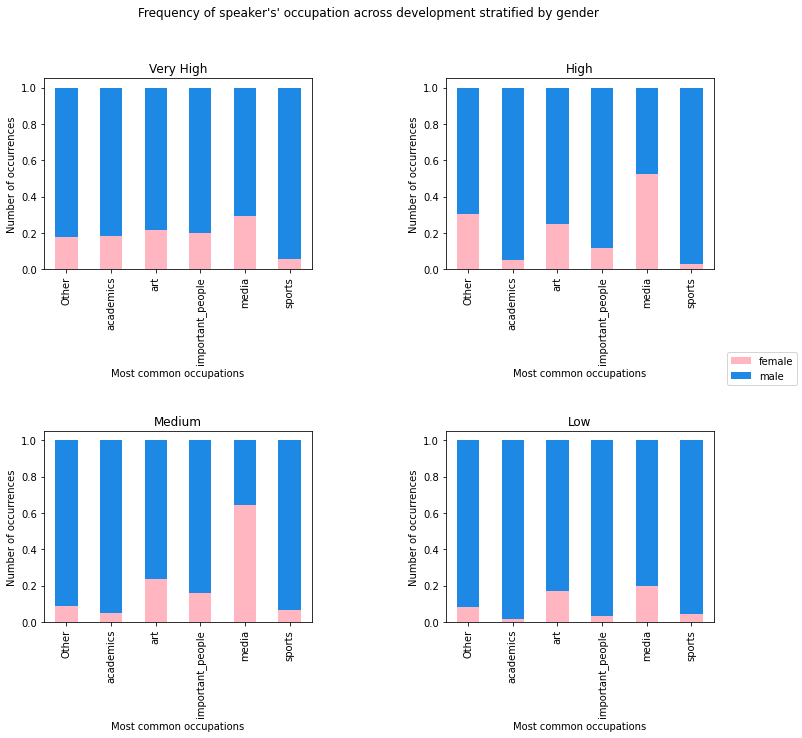

In [ ]:
#Fix legends
fig, [[vhigh,high],[medium,low]] = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
axes = [vhigh,high,medium,low]
Lhdi = ['Very High', 'High', 'Medium', 'Low']
for i in range(4):
    df_class_occ1 = df[df['Development']==Lhdi[i]].explode("Class_Occup")
    class_occup_distribution = df_class_occ1.groupby(['Class_Occup','gender'])['Class_Occup'].count().unstack('gender')
    class_occup_distribution_std = class_occup_distribution.div(class_occup_distribution.sum(axis=1), axis=0)
    if i :
        plot = class_occup_distribution_std.plot(kind='bar',ax=axes[i],stacked=True, legend=False, color=[pink, blue])

    else :
        plot = class_occup_distribution_std.plot(kind='bar',ax=axes[i],stacked=True, legend=False, color=[pink, blue])
    axes[i].set_xlabel("Most common occupations")
    axes[i].set_ylabel("Number of occurrences")
    axes[i].set_title(Lhdi[i])
plt.subplots_adjust(hspace=0.85,wspace=0.5)
plt.suptitle("Frequency of speaker's' occupation across development stratified by gender")
fig.legend(labels=['female','male'], loc="center right")

save_plot_for_website("freq_speakers_class_occup_hdi_gender")

plt.show()

In [ ]:
df_class_occ1 = df[df['Development']==Lhdi[0]].explode("Class_Occup")
class_occup_distribution = df_class_occ1.groupby(['Class_Occup','gender'])['Class_Occup'].count().unstack('gender')
class_occup_distribution_std = class_occup_distribution.div(class_occup_distribution.sum(axis=1), axis=0)

In order to quantify the observations from the previous graph, we visualize the same plot but taking into account the fractions instead of absolute values. 

After the analysis of all the different plots we can finally answer the question "*Are women from developing countries less represented in high-placed occupations?*" 
Indeed, when we look on the speakers from the most relevant spheres (politics, economics and military) in developing countries and in particular those with low HDI index we can see that more than 95% of quotes are men-attributed. This shows that women' voices are silent in these nations and one possible explanation could be that, in some cases, they migth have limited freedom of speech. 
However, this seems to be not true for all developing countries since those with an average HDI index show similar percentage as the highly developed country for the professions in the *important_people* group, which is unexpected. 

## Topic Detection

### Preprocessing

Prior to topic modelling, we convert our keywords series into **bags of words**.
Many words appear very often or very rarely and thus, will not contribute to the extraction of meaningful topics. To deal with that, we
***filter by a frequency interval*** of appearance.

In [ ]:
def quotes_bags_of_words(keywords_series, max_freq=0.15, min_freq = 0.01):
  dictionary = Dictionary(keywords_series)
  min_wordcount = int(keywords_series.shape[0] * min_freq)

  dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
  bags_of_words = keywords_series.apply(dictionary.doc2bow)
  return {"bow": bags_of_words, "dict": dictionary}

### LDA Model

Having prepared the data, we now move on to the actual **topic detection**, which consists in using unsupervised learning to extract the main topics occurring in our dataset. Our model of choice for this task is **Latent Dirichlet Allocation (LDA)** (https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) using the _gensim_ library. 

With this method, each quotation is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words. 
In order to create this model we need to specify the following parameters among others: 
* _passes_: defines how many times we pass through the corpus during training
* _iterations_: maximum number of iterations through the corpus when inferring the topic distribution
* _num topics_: number of topics to extract from the corpus

In particular, two hyperparameters deserve some special attention: 

* **_alpha_**: it represents the "document-topic density". The higher the value, the more numerous the topics in each document. 

* **_beta_**: it represents topic-word density. The higher the value, the more words are within each of the topics.

TODO(mat): elaborate here

Hyperparameter tuning is necessary to obtain a high **topic coherence score**, which is a measure of the quality of a learned topic. More specifically, for each single topic it assesses the degree of semantic similarity between high scoring words in the topic. This score helps distinguishing between topics that are semantically interpretable and those that are artifacts of statistical inference.


In [37]:
def train_topic_detection_model(keywords, hyperparams):
  corpus_data = quotes_bags_of_words(keywords, **hyperparams["bow"])
  corpus = corpus_data["bow"]
  dictionary = corpus_data["dict"]
  print(f"[{datetime.now()}] Training model with params: {hyperparams['model']}")
  return corpus, dictionary, LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    workers=6,
    **hyperparams["model"],
  )


def save_lda_model(lda_model, corpus, year="", num_topics=20):
  lda_model.save(f'/content/drive/MyDrive/ADA/lda_model_{year}__{num_topics}_topics')
  corpus.to_pickle(f'/content/drive/MyDrive/ADA/corpus.pkl')


def load_lda_model(year="", num_topics=20):
  lda_model = LdaMulticore.load(f'/content/drive/MyDrive/ADA/lda_model_{year}__{num_topics}_topics')
  with open('/content/drive/MyDrive/ADA/corpus.pkl', "rb") as fh:
    corpus = pickle.load(fh)
  return corpus, lda_model


def compute_lda_coherence_score(lda_model, keywords, dictionary):
  coherence_model_lda = CoherenceModel(model=lda_model, texts=keywords, dictionary=dictionary, coherence='c_v')
  return coherence_model_lda.get_coherence()


def merge_topics_into_df(df, lda_model, num_topics):
  for j in range(num_topics): 
      df[f'topic_{j}'] = 0.0

  errors_count = 0
  for i in range(len(corpus)):
      bow = corpus[i]
      try:
          for j, x in lda_model[bow]:
              df[f'topic_{j}'].iat[i] = x
      except:
          errors_count += 1

  if errors_count:
    print("Erroneous rows: ", errors_count)


def get_human_readable_topics(model, num_topics, num_words=4):
  topics = model.show_topics(num_words=num_words, num_topics=num_topics, formatted=False)
  return [
    "__".join([word for word, _ in topic])
    for _, topic in topics
  ]


def topic_distribution(df, num_topics):
  return [df[f"topic_{i}"].apply(ceil).sum() for i in range(num_topics)]

### Hypertuning

In [36]:
from datetime import datetime

hypertune_params = {
  "bow": {
    "max_freq": 0.15,
    "min_freq": 0.0005,
  },
  "model": {
    "passes": 1,
    "iterations": 50,
    "random_state": 42,
    "chunksize": 1000,
  },
}

def hypertune_lda_model(train_keywords, hyper):
  topics = [5, 8, 10, 12, 13, 15, 16, 18, 20]
  alphas = list(np.arange(0.01, 0.4, 0.11))

  etas = list(np.arange(0.28, 1, 0.23)) + ['auto']

  best_topics_count = None
  max_coherence = 0

  for num_topics in topics:
    print(datetime.now())
    params = {
      "model": {**hyper["model"], "num_topics": num_topics},
      "bow": {**hyper["bow"]},
    }
    _, dictionary, model = train_topic_detection_model(train_keywords, params)
    coherence_score = compute_lda_coherence_score(model, train_keywords, dictionary)
    if coherence_score > max_coherence:
        best_topics_count = num_topics
        max_coherence = coherence_score
    yield {"alpha": "default", "eta": "default", "num_topics": num_topics, "coherence": coherence_score}

  for alpha, eta in product(alphas, etas):
    print(datetime.now())
    params = {
      "model": {**hyper["model"], "alpha": alpha, "eta": eta, "num_topics": best_topics_count},
      "bow": {**hyper["bow"]},
    }
    _, dictionary, model = train_topic_detection_model(train_keywords, params)
    coherence_score = compute_lda_coherence_score(model, train_keywords, dictionary)
    yield {"alpha": alpha, "eta": eta, "num_topics": best_topics_count, "coherence": coherence_score}

In [ ]:
RUN_HYPERTUNING = False

if RUN_HYPERTUNING:
  train_keywords = df.keywords.sample(frac = 0.0003)
  hypertuning_results = pd.DataFrame(hypertune_lda_model(train_keywords, hypertune_params))
  print("Done! ", datetime.now())
  hypertuning_results.to_pickle("/content/drive/MyDrive/ADA/model_hypertuning.pkl")

In [ ]:
with open("/content/drive/MyDrive/ADA/model_hypertuning.pkl", "rb") as fh:
  hypertuning_results = pickle.load(fh)

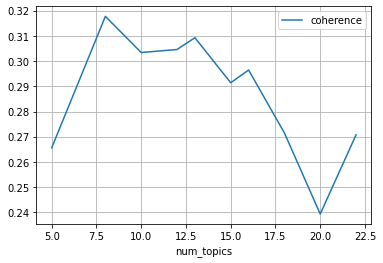

In [ ]:
# TODO: make it look better
hypertuning_results.sort_values('num_topics')[hypertuning_results.alpha == "default"].plot(x="num_topics", y="coherence", grid=True)
save_plot_for_website('hypertuning_topics')
plt.show()

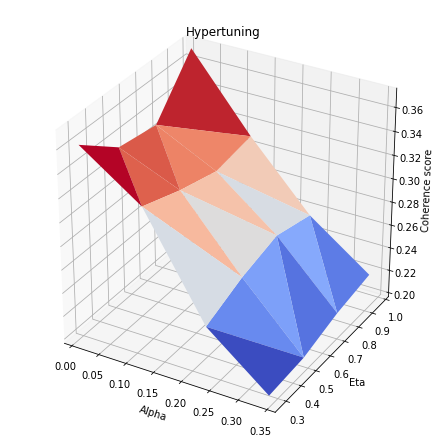

In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


def plot_hypertuning_results(r):
    fig = plt.figure()
    fig.set_size_inches(6, 6)
    ax = Axes3D(fig)

    plt.title('Hypertuning')

    ax.set_xlabel('Alpha')
    ax.set_ylabel('Eta')
    ax.set_zlabel('Coherence score')

    r = r[r.alpha != "default"][r.eta != "auto"]
    ax.plot_trisurf(r.alpha, r.eta, r.coherence, cmap=cm.coolwarm, linewidth=0.2)
    save_plot_for_website('hypertuning_params')
    plt.show()


plot_hypertuning_results(hypertuning_results)

In [ ]:
best_num_of_topics = hypertuning_results.sort_values('coherence', ascending=False)[hypertuning_results.alpha == "default"]

In [ ]:
best_lda_parmas = hypertuning_results.sort_values('coherence', ascending=False).iloc[0]
best_lda_parmas

alpha             0.01
eta               0.97
num_topics           8
coherence     0.372336
Name: 13, dtype: object

In [ ]:
"""
Alpha and Beta Hyperparameters

"""

lda_model_params = {
  "bow": {
    "max_freq": 0.15,
    "min_freq": 0.0005,
  },
  "model": {
    "passes": 15,
    "iterations": 200,
    "random_state": 42,
    "num_topics": best_num_of_topics.iloc[1],
    "chunksize": 2000,
    "alpha": best_lda_parmas.alpha,
    "eta": best_lda_parmas.eta,
  },
}
num_topics = lda_model_params["model"]["num_topics"]

def as_topics_cols(xs):
  return [f"topic_{i}" for i in xs]

### Model training

In [ ]:
train_keywords = df.keywords

In [ ]:
TRAIN_LDA = False

if TRAIN_LDA:
  corpus, dictionary, lda_model = train_topic_detection_model(train_keywords, lda_model_params)
  coherence_score = compute_lda_coherence_score(lda_model, train_keywords, dictionary)
  save_lda_model(lda_model, corpus, num_topics=num_topics)

  print(f"[{datetime.now()}] Coherence: {coherence_score}")
  lda_model.show_topics(num_words=4 , num_topics=num_topics)

In [ ]:
if TRAIN_LDA:
  readable_topics = get_human_readable_topics(lda_model, num_topics, num_words=5)
  readable_topics

In [38]:
LOAD_LDA = True

if LOAD_LDA:
  corpus, lda_model = load_lda_model(num_topics = 13)

In [ ]:
readable_topics = get_human_readable_topics(lda_model, num_topics = 13, num_words=5)
readable_topics

['team__player__club__goal__football',
 'film__story__special__love__space',
 'family__life__woman__friend__final',
 'community__health__area__support__business',
 'year__job__city__season__school',
 'event__car__sport__word__fan',
 'home__system__care__safe__service',
 'country__india__issue__development__world',
 'government__state__party__election__political',
 'case__course__ball__pressure__water',
 'money__line__couple__heart__night',
 'idea__deal__others__world__message',
 'company__market__business__economy__growth']

In [ ]:
MERGE_TOPICS = False

if MERGE_TOPICS:
  merge_topics_into_df(df, lda_model, num_topics)
  df.to_pickle(f"/content/drive/MyDrive/ADA/preprocessed_quotes_{num_topics}_topics.pkl")
  dist = topic_distribution(df, num_topics)

In [45]:
num_topics = 13
with open(f"/content/drive/MyDrive/ADA/preprocessed_quotes_{num_topics}_topics.pkl", 'rb') as fh:
  df_topics = pickle.load(fh)

In [ ]:
df_topics

,numOccurrences,gender,occupation,nationality,keywords,Class_Occup,HDI rank,Development,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,3,male,"[criminal, gangster, terrorist]",[India],"[blast, dutt, close, contact, anees, shooting,...",[Other],131,Medium,2015,0.000000,0.100539,0.099920,0.000000,0.000000,0.099786,0.284495,0.000000,0.113074,0.196430,0.000000,0.099831,0.0
1,4,male,[cricketer],[India],"[case, confirmation, gesticulation, unable, as...",[sports],131,Medium,2015,0.000000,0.322450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322815,0.000000,0.322784,0.0
2,8,male,"[politician, writer, social worker, bibliograp...",[India],"[anchor, regional, global, peace, security, st...","[Other, important_people, art]",131,Medium,2015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.976608,0.000000,0.000000,0.000000,0.000000,0.0
3,4,male,"[politician, writer, social worker, bibliograp...",[India],"[bihar, sharp, intelligence, serious, attentio...","[Other, important_people, art]",131,Medium,2015,0.000000,0.382666,0.000000,0.000000,0.077074,0.000000,0.076782,0.141422,0.087863,0.076488,0.077052,0.076844,0.0
4,2,male,"[politician, writer, social worker, bibliograp...",[India],"[power, society]","[Other, important_people, art]",131,Medium,2015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.943661,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693197,2,male,[association football player],[Burkina Faso],"[state, hole]",[sports],182,Low,2020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.474246,0.474108,0.000000,0.000000,0.0
3693198,2,male,[judge],[Burkina Faso],"[state, hole]",[important_people],182,Low,2020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.474246,0.474108,0.000000,0.000000,0.0
3693199,2,male,"[economist, diplomat, politician]",[Burkina Faso],"[nobody, virus, head, state, government, minis...",[important_people],182,Low,2020,0.099569,0.099701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.593616,0.099728,0.099488,0.000000,0.0
3693200,2,male,"[LGBTIQ+ rights activist, mountaineer, softwar...",[Kyrgyzstan],"[highest, mountain, continent, journey, local,...","[sports, media, academics]",120,Medium,2020,0.152491,0.000000,0.000000,0.117024,0.000000,0.106686,0.000000,0.153347,0.223164,0.099632,0.000000,0.141729,0.0


In [ ]:
def select_topics_subset(df, selected):
  return df[df[as_topics_cols(SELECTED_TOPICS)].sum(axis=1) > 0]

In [ ]:
SELECTED_TOPICS = [1, 2, 3]

select_topics_subset(df_topics, SELECTED_TOPICS)

,numOccurrences,gender,occupation,nationality,keywords,Class_Occup,HDI rank,Development,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,3,male,"[criminal, gangster, terrorist]",[India],"[blast, dutt, close, contact, anees, shooting,...",[Other],131,Medium,2015,0.000000,0.100539,0.099920,0.000000,0.000000,0.099786,0.284495,0.000000,0.113074,0.196430,0.000000,0.099831,0.000000
1,4,male,[cricketer],[India],"[case, confirmation, gesticulation, unable, as...",[sports],131,Medium,2015,0.000000,0.322450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.322815,0.000000,0.322784,0.000000
3,4,male,"[politician, writer, social worker, bibliograp...",[India],"[bihar, sharp, intelligence, serious, attentio...","[Other, important_people, art]",131,Medium,2015,0.000000,0.382666,0.000000,0.000000,0.077074,0.000000,0.076782,0.141422,0.087863,0.076488,0.077052,0.076844,0.000000
8,2,male,"[politician, autobiographer]",[India],"[ministry, woman, development, childrens, 14th...","[important_people, art]",131,Medium,2015,0.000000,0.000000,0.221969,0.076473,0.000000,0.000000,0.062430,0.116418,0.169426,0.062427,0.000000,0.000000,0.287137
10,3,male,"[politician, writer, social worker, bibliograp...",[India],"[spin, bowling, batsman, victory, wish, luck, ...","[Other, important_people, art]",131,Medium,2015,0.358840,0.000000,0.080069,0.000000,0.000000,0.040123,0.000000,0.000000,0.039357,0.279578,0.079932,0.000000,0.119713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693189,5,female,[model],[Namibia],"[ultrasound, lol]",[media],130,Medium,2020,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923
3693194,2,male,[entrepreneur],[Lithuania],"[india, cluster, community, transmission, worr...",[important_people],34,Very High,2020,0.164647,0.000000,0.164766,0.164924,0.000000,0.164746,0.000000,0.164860,0.000000,0.000000,0.000000,0.000000,0.164636
3693199,2,male,"[economist, diplomat, politician]",[Burkina Faso],"[nobody, virus, head, state, government, minis...",[important_people],182,Low,2020,0.099569,0.099701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.593616,0.099728,0.099488,0.000000,0.000000
3693200,2,male,"[LGBTIQ+ rights activist, mountaineer, softwar...",[Kyrgyzstan],"[highest, mountain, continent, journey, local,...","[sports, media, academics]",120,Medium,2020,0.152491,0.000000,0.000000,0.117024,0.000000,0.106686,0.000000,0.153347,0.223164,0.099632,0.000000,0.141729,0.000000


### Generate countries statistics

In [ ]:
import json


const_readable_topics = [
 'team__player__club__goal__football',
 'film__story__special__love__space',
 'family__life__woman__friend__final',
 'community__health__area__support__business',
 'year__job__city__season__school',
 'event__car__sport__word__fan',
 'home__system__care__safe__service',
 'country__india__issue__development__world',
 'government__state__party__election__political',
 'case__course__ball__pressure__water',
 'money__line__couple__heart__night',
 'idea__deal__others__world__message',
 'company__market__business__economy__growth'
 ]

RENAME_COUNTRY = {
 'The Gambia': 'Gambia',
 'Guinea-Bissau': 'Guinea Bissau',
 'Republic of the Congo': 'Republic of Congo',
 'Serbia': 'Republic of Serbia',
}

def cons_countries_summaries(df_topics):
  df_topics['count'] = 1
  gr = df_topics.explode('nationality').groupby(['nationality', 'gender'])
  df = gr.sum()
  df = df.rename(columns=dict(zip(as_topics_cols(range(13)), const_readable_topics)))
  return df


def country_stats(country_df):
    try:
      male = country_df.loc['male']
    except KeyError:
      male = pd.Series(0, index=df.columns)

    try:
      female = country_df.loc['female']
    except KeyError:
      female = pd.Series(0, index=df.columns)

    if male['count'] == 0 and female['count'] == 0:
      return None

    all = male.add(female)
    return {
        'male_frac': round((male['year'] / all['year']) * 100, 2),
        'most_popular_topic': all[const_readable_topics].idxmax(),
        'total_quotes': int(all['count']),
        'total_citations': int(all['numOccurrences']),
        'avg_citations_female': round(female['numOccurrences'] / (female['count'] or 1), 1),
        'avg_citations_male': round(male['numOccurrences'] / (male['count'] or 1), 1),
    }

def calc_stats_for_website(df):
  countries = df.index.get_level_values('nationality').unique()

  return {
      RENAME_COUNTRY.get(country, country): country_stats(df.loc[country])
      for country in countries
      if country_stats(df.loc[country]) is not None
  }


def save_stats(stats):
  with open("/content/drive/MyDrive/ADA/website/countries_stats.json", "w") as f:
    json.dump(stats, f)

In [ ]:
GEN_STATS_FOR_WEBSITE = False

if GEN_STATS_FOR_WEBSITE:
  save_stats(calc_stats_for_website(cons_countries_summaries(df_topics)))

### Graphs for topics


In the previous sections we made an in-depth analysis putting our attention more on the speakers profile (country of origin and its development index, occupation). Here we would like to shift our focus not on "*who's the speaker?*" but more on "*what does the speaker talk about?*". For this purpose we trained a LDA model for the topic detection task and try to understand the different tendencies in subjects in women and men speakers. More precisely, we try to answer this question:

*  *Can we classify topics into male-oriented and female-oriented?* 

Here below we also added some interactive plots to have a better visualisation of the topics, using *Plotly*, *WordCloud* and *gensim* libraries.



In [ ]:
Ltopics = ['topic_'+str(i) for i in range(13)]
df_topics_male = df_topics[df_topics['gender']=='male'][Ltopics+['year']]
df_topics_female = df_topics[df_topics['gender']=='female'][Ltopics+['year']]

readable_columns = {}
for i in range(13):
    readable_columns['topic_'+str(i)] = readable_topics[i]
df_topics_male = df_topics_male.rename(columns=readable_columns)
df_topics_female = df_topics_female.rename(columns=readable_columns)

topics_occ_male = [df_topics_male[df_topics_male['year']==2015+i][readable_topics].sum(axis=0) for i in range(6)]
topics_occ_female = [df_topics_female[df_topics_female['year']==2015+i][readable_topics].sum(axis=0) for i in range(6)]
topics_occ_male += [df_topics_male[readable_topics].sum(axis=0)]
topics_occ_female += [df_topics_female[readable_topics].sum(axis=0)]

df_topics2=df_topics[Ltopics+['year']]
df_topics2[df_topics2<0.1]=0
df_topics2 = df_topics2.rename(columns=readable_columns)
topics_occ = df_topics2[readable_topics].astype(bool).sum(axis=0)


In [ ]:
topics_occ.sort_values(ascending=False).index

Index(['team__player__club__goal__football',
       'government__state__party__election__political',
       'country__india__issue__development__world',
       'company__market__business__economy__growth',
       'community__health__area__support__business',
       'family__life__woman__friend__final', 'year__job__city__season__school',
       'home__system__care__safe__service',
       'case__course__ball__pressure__water',
       'money__line__couple__heart__night',
       'film__story__special__love__space',
       'idea__deal__others__world__message', 'event__car__sport__word__fan'],
      dtype='object')

First of all, we tried to identify which are the most common topics across all the years and how many quotes are related to each of these topics.

In [ ]:
topics_occ.sort_values(ascending=False)
palette = px.colors.qualitative.Light24[:13]
fig = px.bar(df, x=topics_occ.sort_values(ascending=False).values, 
             y=topics_occ.sort_values(ascending=False).index, color=palette,
             orientation='h', template="plotly_white")

fig.update_layout(showlegend=False, title = 'Topic distribution')
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Count')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey', gridcolor=grey, title='Topics (represented by keywords)')

save_plot_for_website('topics_horizontal_bar', fig)
fig.show()

The most prevalent topics observed are sport- and politics-related. This result was expected since an important percentage of quotes come from the developed country where the occupations involving sports, politics, economics and military are the most represented.  

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Male', 'Female'])

for i in range(7):
    fig.add_trace(go.Pie(values=topics_occ_male[i].values, labels=topics_occ_male[i].index, 
                        name="Male",marker= {
      'colors': px.colors.qualitative.Light24},sort = False), 1, 1)
    fig.add_trace(go.Pie(values=topics_occ_female[i].values, labels=topics_occ_female[i].index, 
                        name="Female",sort = False), 1, 2)

steps = []
for i in range(7):
    if i == 6:
        step = dict(method="update",
        args=[{"visible": [not bool(i-j//2) for j in range(14)]},
              {"title": "Total"}], label="Total")
    else :
        step = dict(method="update",
        args=[{"visible": [not bool(i-j//2) for j in range(14)]},
              {"title": "Year: " + str(2015+i)}], label=str(2015+i))
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Year change "},
    pad={"t": 50},
    steps=steps)]

fig.update_layout(sliders=sliders)
save_plot_for_website('topics_dist_piechart', fig)
fig.show()

After a first superficial analysis of the most quoted topics, we went a step further and try to see if there are some topics which are more related to a specific gender and whether there is a trend across the different years. By looking at the graph combining all the years together, we can define some topics which are more prevalent in men and women. As expected, the most striking disparity between male and female speakers can be found within the sport sphere, more precisely concerning football. As already mentioned above, the sport world has been historically male-dominated, thus it's not a very surprising fact. At the same time we can also notice that topics more present in women-attributed quotes are related to love, house and family. These observations further consolidates the stereotypical and romanticized image of the women in the society. Nonetheless, it's interesting to notice that one topic which seems to be slightly more discussed among women than men is about politics. Concerning this fact it could be interesting to investigate about the countries in which this trend is present.


Here we create a plot showing the most prevalent words for each topic. We can see that the majority of them are strongly related, however we can still find some words in the same topic which don't necessarily have a direct semantic connection. It's important to remember that the relevant words are selected thanks to a trained model. This shows that, despite obtaining already good results, our model still has room for improvement. 

In [ ]:
#TO DO: Fix grouping of WordClouds
from wordcloud import WordCloud

#cloud = WordCloud(width = 500, height = 250, background_color="white").fit_words(dict(lda_model.show_topic(t, 6)))

gc.collect()
cloud = WordCloud(background_color='white',max_words=6,
                 )

topics = lda_model.show_topics(num_topics=13, formatted=False)

fig, axes = plt.subplots(6, 2, figsize=(200,100), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i))
    plt.gca().axis('off')

#plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()

save_plot_for_website('topics_cloud')
plt.show()

A complete visualizations of the topic clusters, found using the LDA model, can be easily obtained thanks to a function present in the gensim library. On the left side there is a the resulting of a PCA analysis of the all the considered topics which are represented as circles of different dimensions. On the other hand, at right, there is a histogram representing the 30 most common word in general and their occurences. When clicking on a certain circle in the graph on the left, we will have obtain on the right side the distribution of the 30 most common words for the topic in red and in light blue their absolute occurences (across all the topics).

In [41]:
gc.collect()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, lda_model.id2word, n_jobs=1)
plot = pyLDAvis.display(vis)

In [ ]:
with open(f'/content/drive/MyDrive/ADA/website/_includes/plots/topic_distance_map.html', "w") as f : 
  f.write(plot.data)

In [42]:
plot

## Statistical testing

In this section we would like to test whether there is a significant difference:
* between the success of quotes attributed to men vs women, measured in terms of _numOccurrences_
* between the success of quotes attributed to women from developing vs developed countries, always measured in terms of _numOccurrences_. In order to do so, we will divide the dataset in 2 groups:
  * quotes with speakers from countries with _Very High_ and _High_ development index. 
  * quotes with speakers from countries with _Medium_ and _Low_ dvelopment index. 

Our method of choice for both tests is a **non-parametric test**, more precisely the **two-sample Kolmogorov-Smirnov test** test. The advantage of this method over a classic parametric t-test is that it does not make any assumption about the distribution of the test statistic (no normality of data). It compares the underlying continuous distributions F(x) and G(x) of two independent samples, whose size can be different. 
This is the case here since in both the tests to perform one group outnumbers the other, the men-attributed quotes for the first test and the _Very High_/_High_ subset for the second one.

In the following tests we would like to answer the following questions: 
1. _Are women-attributed quotes less successful than men-attributed quotes?_

1. Are quotes attributed to women from developing countries less successful than those attributed to women from developed countries?

For the sake of our reserch questions, we are more interested in performing **one-sided** tests. The desired null hypothesis and corresponding alternative hypothesis that can be selected by setting the _alternative parameter_ in the test to:

* less: The null hypothesis is that F(x) >= G(x) for all x; the alternative is that F(x) < G(x) for at least one x.

* greater: The null hypothesis is that F(x) <= G(x) for all x; the alternative is that F(x) > G(x) for at least one x.

It is important to note that that the alternative hypotheses describe the **CDFs of the underlying distributions, not the observed values**. For example, if we suppose that x ~ F and y ~ G, if F(z) > G(z) for all x, the values in x tend to be less than those in y.

The tests returns a **D test statistic** and a **p-value** corresponding to the test statistic. The results can be interpreted as follows: 
* The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0, the more likely it is that the two samples were drawn from the same distribution. 
* if the returned p_value is smaller than a significance level **_alpha_**, set here to 0.05,  we can reject the null hypothesis.

**Note**: since we will be performing multiple tests using the same dataset (2 in this section and 1 in the following one), we will adjust our significance value _alpha_ with the **Bonferroni correction**: 

$alpha'= \frac{alpha}{k}$
where k is the number of individual independent tests that we are performing. Our updated alpha' is thus 0.016.



**_Are women-attributed quotes less successful than men-attributed quotes?_**

In [59]:
Counter(df_topics['gender'])

Counter({'male': 3147268, 'female': 545934})

In [60]:
# Convert the gender variable to a binary one 
df_topics['gender'] = df_topics['gender'].apply(lambda x: 0 if x == 'female' else 1)

# Remove outliers
df_topics.drop(df_topics[df_topics.numOccurrences > 10000].index, inplace = True)

In [61]:
Num_occ_male = df_topics[df_topics['gender'] == 1]['numOccurrences']
Num_occ_female = df_topics[df_topics['gender'] == 0]['numOccurrences']


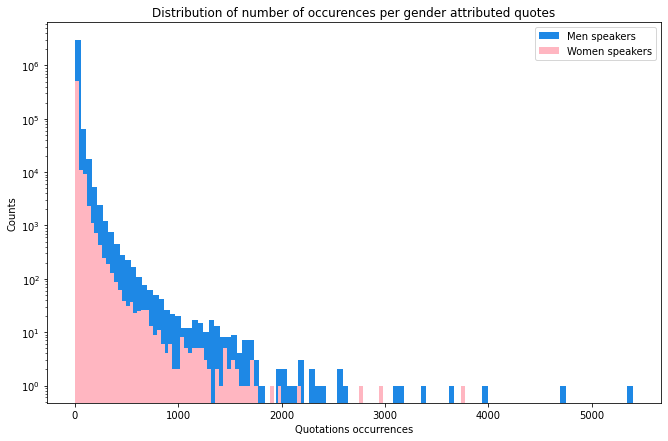

In [62]:
kwargs = dict(alpha=1, bins=100)
plt.figure(figsize=(11, 7))
plt.hist(Num_occ_male, **kwargs,color=blue, label='Men speakers', log = True,  histtype = 'stepfilled')
plt.hist(Num_occ_female, **kwargs, color=pink, label='Women speakers', log = True,  histtype = 'stepfilled')
plt.gca().set(title='Distribution of number of occurences per gender attributed quotes', ylabel='Counts', xlabel = 'Quotations occurrences')
plt.legend();
# save_plot_for_website("num_occur_gender_quotes")

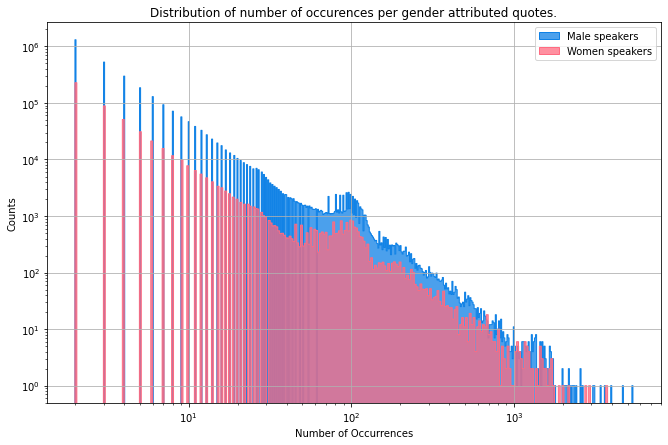

In [63]:
#To better visualize the data
import seaborn as sns
plt.figure(figsize = (11, 7))
plot1 = sns.histplot(Num_occ_male, log_scale = (True, True), color = dark_blue, label = 'Male speakers',element = "step")
plot2 = sns.histplot(Num_occ_female, log_scale = (True, True), color = dark_pink, label = 'Women speakers',element = "step")
plt.title("Distribution of number of occurences per gender attributed quotes.")
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")

plt.grid()
plt.legend()
plt.show()

save_plot_for_website("num_occur_gender_quotes", plot2.get_figure())

**Observation**: we observe that the two distributions of number of occurences for men-attributed and women-attributed quotes are similar and both very skewed: they follow a power-law. For both distributions fewer quotes have appeared in the media a very large number of times ( > 3000). We also observe that across the entire range of quotation occurrences men counts outnumber the female counts, which is expected given the bigger presence of men speakers-attributed quotes with respect to women ones. 


In [64]:
from scipy import stats

# We hypothesize that Num_occ_female < Num_occ_male, so the condition is inversed for their distributions

stat, p = stats.ks_2samp(Num_occ_female, Num_occ_male ,alternative = 'greater')

In [65]:
print('Statistics = ', stat, 'p = ' , p)
# interpret
alpha = 0.016
if p > alpha:
	print(' We fail to reject H0)')
else:
	print('There is a statistically significant evidence to reject the null hypothesis.')

Statistics =  0.0009404173717164621 p =  0.4388450576081905
 We fail to reject H0)


**Conclusion**: We do not have statistical evidence to reject the null hypothesis, therefore we cannot conclude that the women speakers-attributed quotes are less successful than the male-attributed ones. It seems that women struggle more to gain the media's attention with respect to men (women-attributed quotes << men-attributed quotes), but once that step is past they are equally successful as men.

**_Are quotes attributed to women from developed countries less successful than those attributed to women from developing countries?_** 

In [66]:
# The women from developed crountries outnumber those from developing ones

women_developed_group = df_topics[((df_topics['Development'] == 'High') | (df_topics['Development'] =='Very High')) & (df_topics['gender'] == 0)]['numOccurrences']
women_developing_group = df_topics[((df_topics['Development'] == 'Medium') | (df_topics['Development'] =='Low')) & (df_topics['gender'] == 0)]['numOccurrences']
print('Size of the developed group: ', len(women_developed_group))
print('Size of the developing group: ', len(women_developing_group))

Size of the developed group:  473642
Size of the developing group:  72291


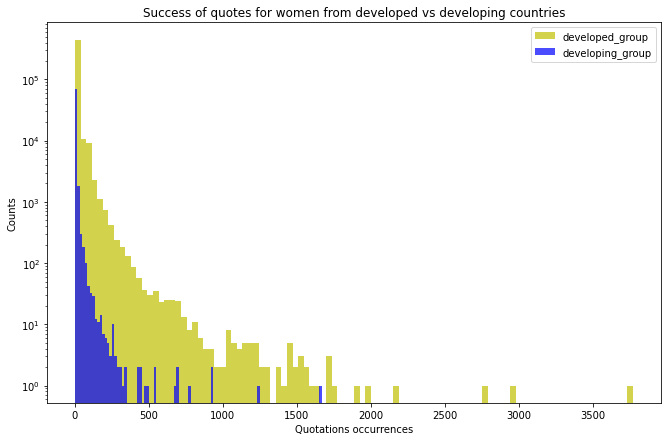

In [67]:
kwargs = dict(alpha=0.7, bins=100)
plt.figure(figsize=(11, 7))
plt.hist(women_developed_group, **kwargs,color='y', label='developed_group', log = True, histtype = 'stepfilled')
plt.hist(women_developing_group, **kwargs, color='b', label='developing_group', log = True, histtype = 'stepfilled')
plt.gca().set(title='Success of quotes for women from developed vs developing countries', ylabel='Counts', xlabel = 'Quotations occurrences')

plt.legend();

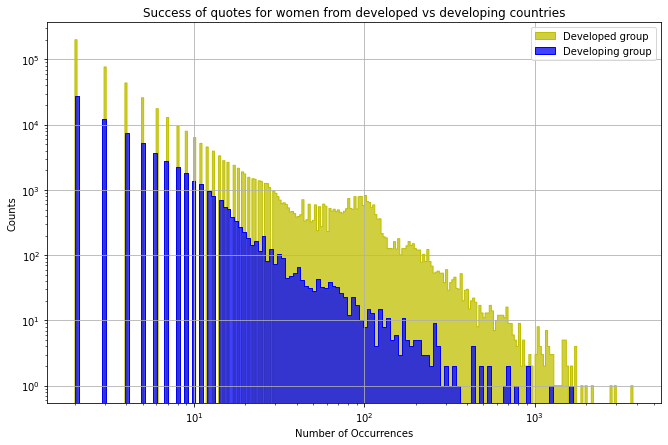

In [68]:
#To better visualize the data
import seaborn as sns
plt.figure(figsize = (11, 7))
sns.histplot(women_developed_group, log_scale = (True, True), color = 'y', label = 'Developed group',element = "step")
plot = sns.histplot(women_developing_group, log_scale = (True, True), color = 'b', label = 'Developing group',element = "step")
plt.title('Success of quotes for women from developed vs developing countries')
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")

plt.grid()
plt.legend()
plt.show()

save_plot_for_website("success_quote_woman_country_dev", plot.get_figure())

In [34]:
stat, p = stats.ks_2samp(women_developed_group, women_developing_group, alternative ='less' )

In [35]:
print('Statistics = ', stat, 'p = ' , p)
if p > alpha:
	print(' We fail to reject H0)')
else:
	print('There is a statistically significant evidence to reject the null hypothesis.')

Statistics =  0.06267633261198668 p =  9.507826083115674e-215
There is a statistically significant evidence to reject the null hypothesis.


We found statistical evidence that quotes attributed to women from developed countries are more present in the media with respect to those from developing countries. The statistic found is very close to 0, which still indicates a high similarity between the distributions.
However, we are aware that when computing the p-value on very big sample sizes, it can very often get arbitrarily small. This limits the extent to which we can make meaningful use of the p_values obtained in the previous analyses. 


## Correlation analysis

In this section we would like to perform a correlation analysis between the _gender_ and _occupation_ categorical variables. For this purpose we decided to do **a chi-squared test of independence** on these variables, rearranged in a contingency table. We have the following hypotheses: 
1. Null hypothesis: they are independent: thus, we expect the values in the contingency table to be uniformly distributed.
1. Alternative hypothesis: they are correlated in some way.

However, being aware that a statistically significant chi-square could just be the result of large sample size instead of substantive relationship between the variables, given a low p-value, we would like to determine the strength of a relationship between the categorical variables. One efficient way for doing this is to use the **Cramer V** score, an effect size statistic that ranges from 0 to 1, for very weak to very strong associations. It can be computed from the chi-squared statistic with the formula below: 

$Cramer V = √\frac{(X2/n)}{min(c-1, r-1)}$

where _X2_ is the chi squared statistic, _n_ is the total sample size, _r_ is the number of rows and _c_ the number of columns in the contingency table. 

**Note**: since in our dataset the number of quotes attributed to men-speakers outnumbers by far the the number of quotes attributed to women-speakers, we first balance the dataset by **undersampling** the first group so that it matches the size of the second one. The purpose is to avoid observing a strong correlation between the male gender and occupations only because of an unbalanced dataset. 

In [ ]:
Class_Occup_dummies = pd.get_dummies(df_topics.Class_Occup.explode())
jobs_columns = [f'{Class_Occup}_jobs' for Class_Occup in Class_Occup_dummies.columns] 
Class_Occup_dummies.columns = jobs_columns
summed_class = Class_Occup_dummies.groupby(Class_Occup_dummies.index).sum()
df_topics = pd.concat([df_topics, summed_class], axis = 1)
df_topics.head()

,numOccurrences,gender,occupation,nationality,keywords,Class_Occup,HDI rank,Development,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,Other_jobs,academics_jobs,art_jobs,important_people_jobs,media_jobs,sports_jobs
0,3,1,"[criminal, gangster, terrorist]",[India],"[blast, dutt, close, contact, anees, shooting,...",[Other],131,Medium,2015,0.0,0.100539,0.09992,0.0,0.000000,0.099786,0.284495,0.000000,0.113074,0.196430,0.000000,0.099831,0.0,1,0,0,0,0,0
1,4,1,[cricketer],[India],"[case, confirmation, gesticulation, unable, as...",[sports],131,Medium,2015,0.0,0.322450,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.322815,0.000000,0.322784,0.0,0,0,0,0,0,1
2,8,1,"[politician, writer, social worker, bibliograp...",[India],"[anchor, regional, global, peace, security, st...","[Other, important_people, art]",131,Medium,2015,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.976608,0.000000,0.000000,0.000000,0.000000,0.0,1,0,1,1,0,0
3,4,1,"[politician, writer, social worker, bibliograp...",[India],"[bihar, sharp, intelligence, serious, attentio...","[Other, important_people, art]",131,Medium,2015,0.0,0.382666,0.00000,0.0,0.077074,0.000000,0.076782,0.141422,0.087863,0.076488,0.077052,0.076844,0.0,1,0,1,1,0,0
4,2,1,"[politician, writer, social worker, bibliograp...",[India],"[power, society]","[Other, important_people, art]",131,Medium,2015,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.943661,0.000000,0.000000,0.000000,0.0,1,0,1,1,0,0


In [ ]:
Num_occ_male = df_topics[df_topics['gender'] == 1]
Num_occ_female = df_topics[df_topics['gender'] == 0]

# Undersampling the male group to match the female group size
Num_occ_male = Num_occ_male.sample(n=Num_occ_female.shape[0])
balanced = pd.concat([Num_occ_male, Num_occ_female], axis = 0)


In [ ]:
Counter(balanced['gender'])

Counter({1: 545933, 0: 545933})

In [ ]:
# https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas

from scipy.stats import chi2_contingency
import numpy as np

def find_correlation(df, pairs):
  """
  Find correlation using a chi squared test
  """

  chi2, p_values =[], []

  for pair in pairs:
          chitest = chi2_contingency(pd.crosstab(df[pair[0]], df[pair[1]]))   
          chi2.append(chitest[0])
          p_values.append(chitest[1])
  stat = pd.DataFrame([chi2, p_values], index = ['chi2 stat', 'pvalue'], columns = [occ + '- gender' for _, occ in pairs])
  return stat

def compute_Crammers_V(df, pairs):
  """
  Find Crammers_V using a chi squared test
  """

  V_scores =[]

  for pair in pairs:
          tab = pd.crosstab(df[pair[0]], df[pair[1]])
          chi_stat = chi2_contingency(tab)   
          n = np.sum(np.sum(tab))
          minDim = min(tab.shape)-1
          V_scores.append(np.sqrt((chi_stat[0]/n)/minDim))
  stat = pd.DataFrame([V_scores], index = ['Crammers_V'], columns = [occ + '- gender' for _, occ in pairs])
  return stat

In [ ]:
pairs = [['gender', 'Other_jobs'], ['gender', 'important_people_jobs'], ['gender', 'sports_jobs'], ['gender', 'media_jobs'], ['gender', 'academics_jobs'], ['gender', 'art_jobs']]

In [ ]:
pd.crosstab(balanced.explode('Class_Occup').reset_index()['gender'], balanced.explode('Class_Occup').reset_index()['Class_Occup'])

Class_Occup,Other,academics,art,important_people,media,sports
gender,,,,,,
0,138763,56544,212061,261417,125110,76549
1,116134,52317,128878,207706,43241,230521


In [ ]:
results = find_correlation(balanced, pairs)
results

,Other_jobs- gender,important_people_jobs- gender,sports_jobs- gender,media_jobs- gender,academics_jobs- gender,art_jobs- gender
chi2 stat,2620.520647,10781.62114,107412.056975,47069.33365,1.822218e+02,29508.94317
pvalue,0.000000,0.00000,0.000000,0.00000,1.586105e-41,0.00000


In [ ]:
crammer_scores = compute_Crammers_V(balanced, pairs)
crammer_scores

,Other_jobs- gender,important_people_jobs- gender,sports_jobs- gender,media_jobs- gender,academics_jobs- gender,art_jobs- gender
Crammers_V,0.04899,0.09937,0.313648,0.207627,0.012919,0.164396


**Interpretation**: 
We observe that for all pairs we obtain very low p-values, meaning that the variables in each pair are somehow correlated. However, by looking at the corresponding Crammers_V scores we can tell that the strongest (still relatively low) correlations are observed between _sports jobs_ and _gender_, _media jobs_ and _gender_, and _art jobs_ and _gender_. This is coherent with the values observed in the contingency table and in our previous graphs, indicating that there is a prevalence of women in _art jobs_ and _media jobs_, whereas of men in _sports jobs_. 

## Linear regression model

In the following section, we try to fit a linear model to the data, with outcome variable the number of occurrences of a given quote based on the features studied in the previous sections. The aim is not to be able to predict the number of occurrences for a new quote, but to study the coefficients reported by the model to deduce their influence on the outcome.  

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import scipy.stats as stats

# Now we fit a linear model to predict the number of occurrences

dataset = df_topics
mod = smf.ols(formula = 'numOccurrences ~ C(gender * academics_jobs) + C(gender * important_people_jobs) + C(gender * sports_jobs) + C(gender * media_jobs) + C(gender * Development)+ topic_0  \
                        + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + topic_12' , data=df_topics)

stat = mod.fit()
print(stat.summary())

                            OLS Regression Results                            
Dep. Variable:         numOccurrences   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     393.3
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:11:20   Log-Likelihood:            -1.9547e+07
No. Observations:             3693202   AIC:                         3.909e+07
Df Residuals:                 3693180   BIC:                         3.909e+07
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In the table above we can see that there only there are only four positive coefficients, and more precisely there are only two higher than one. This suggests that the only parameters having a clear positive influence are the gender, the development level of the country and the class of occupation. Some coefficients even if they are positive they are very close to 0 so their impact on the number of citations of the quotes is negligeable. What we can conclude is that there are three main features contributing to the success of a quote: being a woman, in a highly developped country and working in either political, economical or military spheres. 
